**Lab 4** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Machine Learning for Audio and Acoustic Engineering***
---

Implementation on PyTorch


# **Lab 4: Neural Networks (II)**
---

In this lab we will continue exploring different types of deep architectures for audio processing, and we will pay special attention to system evaluation.


In [ ]:
# As always, we import the relevant packages
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from tqdm import tqdm
from pathlib import Path


## Device Selection

In [ ]:
cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

Device Check:

In [ ]:
device

device(type='mps')

### **Exercise 1**: Data Preparation I

We will continue working with the ESC-50 dataset. Download it to your notebook following the same steps as in Lab 2 and Lab 3.

In [9]:
!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
!unzip master.zip

zsh:1: command not found: wget
unzip:  cannot find or open master.zip, master.zip.zip or master.zip.ZIP.


Create a list containing the audio files and another one with the corresponding labels (as in Lab 3):

In [15]:
fn_csv = '/Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Selected Topics in Music and Acoustic Engineering 👨🏻‍🏫/Codes STMAE/ESC-50-master/meta/esc50.csv'

files = []  # File list
labels = []  # Class list

df = pd.read_csv(fn_csv)

#unique class labels
unique_classes = df['category'].unique()

Instead of working with 50 classes, we limit our dataset to only 10 classes. Filter you two files (the one with file paths and the one with labels) to contain only those belonging to classes [0-9].

In [16]:
# 10 first classes
our_classes = unique_classes[0:10]
print("First 10 classes:", our_classes)

# Filter the dataset to only include the selected classes
filtered_df = df.query('category in @our_classes')

files = filtered_df['filename'].values
labels = filtered_df['category'].values

First 10 classes: ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw']


We load the signals and get the Mel spectrogram for each signal. Create a list called "signals" storing the raw waveforms of each file in your list and another one called "melspecs" that stores the Mel spectrogram for each signal.

Note: use the default parameters for librosa.load (resample to 22050Hz) and librosa.feature.melspectrogram.

In [17]:
path = '/Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Selected Topics in Music and Acoustic Engineering 👨🏻‍🏫/Codes STMAE/ESC-50-master/audio/'
signals = list(librosa.load(path + file)[0] for file in files)

signal1, sr = librosa.load(path + '1-100032-A-0.wav')
print(sr)

melspecs = list(librosa.feature.melspectrogram(y=signal, sr=sr) for signal in signals)

22050


### **Exercise 2**: Data preparation II



Convert your "melspecs" and "labels" list to numpy arrays, called "Xdata" and "Ydata".
Check that the result has size (400, 128, 216) for Xdata and (400,) for Ydata.

In [18]:
Xdata = np.asarray(melspecs)

# Transform the labels to numbers
label_mapping = {label: idx for idx, label in enumerate(dict.fromkeys(labels))}
numerical_labels = np.array([label_mapping[label] for label in labels])

Ydata = np.asarray(numerical_labels)

print('Xdata shape: {} \nYata shape: {}'.format(Xdata.shape, Ydata.shape))

Xdata shape: (400, 128, 216) 
Yata shape: (400,)


Check that Ydata is balanced by plotting the histogram.

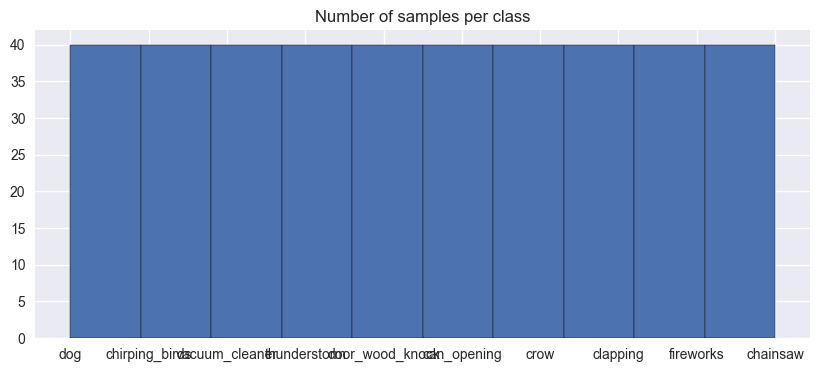

In [19]:
plt.figure(figsize=(10, 4))
plt.title("Number of samples per class")
plt.hist(labels, bins=10,edgecolor='black')
plt.show()

As we can see from the histogram, we have exactly the same number of element for each class.

Split your dataset into 3 partitions, 1 for training (70%), 1 for validation (20%) and 1 for test (10%). Check that the resulting arrays have the correct shape:

In [20]:
seed = 42 # We set a seed for reproducibility

X_train, X_temp, y_train, y_temp = train_test_split(Xdata, Ydata, train_size=0.7, random_state=seed, stratify=Ydata) #we use stratify to keep the same distribution of classes in the training set

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=seed, stratify=y_temp)  #we use stratify to keep the same distribution of classes in the validation and test sets
print('X_train shape: {} \nX_val shape: {} \nX_test shape: {} \ny_train shape: {} \ny_val shape: {} \ny_test shape: {} \n'.format(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))


X_train shape: (280, 128, 216) 
X_val shape: (80, 128, 216) 
X_test shape: (40, 128, 216) 
y_train shape: (280,) 
y_val shape: (80,) 
y_test shape: (40,) 



Expected output:
```
X_train shape: (280, 128, 216)
X_val shape: (80, 128, 216)
X_test shape: (40, 128, 216)
y_train shape: (280,)
y_val shape: (80,)
y_test shape: (40,)
```

In the next exercise we will create a time-distributed 1D-CNN to process our dataset. By default, Keras assumes that the last dimension corresponds to the number of channels in our input. Since we are going to use 1D-CNN, each frequency band will be processed as an independent frequency channel. Therefore, we need to reorder the dimensions in our data to move the frequency channels to the last dimension.

Use the numpy function "moveaxis" to create the data matrices X_train_rs, X_val_rs and X_test_rs, with dimensions (280, 216, 128), (80, 216, 128) and (40, 216, 128):

In [21]:
X_train_rs = np.moveaxis(X_train, 1, -1)
X_val_rs = np.moveaxis(X_val, 1, -1)
X_test_rs = np.moveaxis(X_test, 1, -1)

print('X_train_rs shape: {} \nX_val_rs shape: {} \nX_test_rs shape: {}'.format(X_train_rs.shape, X_val_rs.shape, X_test_rs.shape))

X_train_rs shape: (280, 216, 128) 
X_val_rs shape: (80, 216, 128) 
X_test_rs shape: (40, 216, 128)


Expected output:
```
X_train_rs shape: (280, 216, 128)
X_val_rs shape: (80, 216, 128)
X_test_rs shape: (40, 216, 128)
```

### **Exercise 7**: Hybrid CNN-RNN

In this last exercise we are going to mix our previous time-distributed model with a LSTM layer to create a Hybrid CNN-RNN architecture.

Adapt your previous time-distributed model to match the following summary:

In [32]:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #

# Time-Dist Conv1D             (None, None, 120, 16)     160
# _________________________________________________________________
# Time-Dist MaxPool1D 1D       (None, None, 60, 16)      0
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 60, 16)      0
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 58, 16)      784
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 29, 16)      0
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 29, 16)      0
# _________________________________________________________________
# Time-Dist Conv1D             (None, None, 27, 32)      1568
# _________________________________________________________________
# Time-Dist Dropout (0.5)      (None, None, 27, 32)      0
# _________________________________________________________________
# Time-Dist MaxPool1D          (None, None, 14, 32)      0
# _________________________________________________________________
# Time-Dist Flatten            (None, None, 448)         0
# _________________________________________________________________
# LSTM  (16 neurons)           (None, None, 16)          29760
# _________________________________________________________________
# Global Av. Pooling 1D        (None, 16)                0
# _________________________________________________________________
# Dropout (0.35)               (None, 16)                0
# _________________________________________________________________
# Dense                        (None, 10)                170

# Total params: 32,442
# Trainable params: 32,442
# Non-trainable params: 0
# _________________________________________________________________


This time, we assign names to the layers in order to recognise them in the summary.

In [102]:
#Create a time distributed model
input_shape=(None, X_train_rss.shape[2], X_train_rss.shape[3])
print('INPUT SHAPE:',input_shape)
model_hyb=tf.keras.models.Sequential()
model_hyb.add(tf.keras.Input(shape=input_shape))

#1st Conv layer
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(16, 9, activation='relu', name='CONV1')))
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same', name='MP1')))
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))

#2nd Conv layer
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(16, 3, activation='relu', name='CONV2')))
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same', name='MP2')))
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))

#3rd Conv layer
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 3, activation='relu', name='CONV3')))
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(2, padding='same', name='MP3'))) #flat the output
model_hyb.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten (name='FLATTEN')))

#LSTM part
model_hyb.add(tf.keras.layers.LSTM(16, name="LSTM", return_sequences=True))
model_hyb.add(tf.keras.layers.GlobalAveragePooling1D())
model_hyb.add(tf.keras.layers.Dropout(0.35))

#output layer
model_hyb.add(tf.keras.layers.Dense(10, activation='softmax', name='SOFTMAX'))
model_hyb.summary()

INPUT SHAPE: (None, 128, 1)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_22             │ (None, None, 120, 16)  │           160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, None, 60, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, None, 60, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, None, 58, 16)   │           784 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, None, 29, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, None, 29, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, None, 27, 32)   │         1,568 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, None, 27, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, None, 14, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, None, 448)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, None, 16)       │        29,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SOFTMAX (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,442 (126.73 KB)

 Trainable params: 32,442 (126.73 KB)

 Non-trainable params: 0 (0.00 B)

Train the network using the same procedure as in previous tasks.

In [103]:
# CSVLogger
csv_logger = CSVLogger('training_1D_CNN_hyb.log', append=False)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

#model checkpoint
model_name = 'CNN_1D_model_hyb.h5'
model_checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, verbose=1)

#store all these callbacks in a list, Callback list
callbacks = [csv_logger, early_stopping, model_checkpoint]

# Compile the model
learning_rate=0.001
batch_size=32
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_hyb.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fitting
history_hyb = model_hyb.fit(X_train_rss, y_train, batch_size=batch_size, epochs=1000, validation_data=(X_val_rss, y_val), callbacks=callbacks)

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1378 - loss: 2.2887
Epoch 1: val_accuracy improved from -inf to 0.23750, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 119s 7s/step - accuracy: 0.1373 - loss: 2.2874 - val_accuracy: 0.2375 - val_loss: 2.1884
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2417 - loss: 2.1585
Epoch 2: val_accuracy improved from 0.23750 to 0.28750, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.2386 - loss: 2.1581 - val_accuracy: 0.2875 - val_loss: 2.0890
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2396 - loss: 2.0844
Epoch 3: val_accuracy improved from 0.28750 to 0.32500, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.2417 - loss: 2.0830 - val_accuracy: 0.3250 - val_loss: 2.0035
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3477 - loss: 1.9551
Epoch 4: val_accuracy improved from 0.32500 to 0.38750, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.3447 - loss: 1.9577 - val_accuracy: 0.3875 - val_loss: 1.9254
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3893 - loss: 1.8963
Epoch 5: val_accuracy improved from 0.38750 to 0.40000, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.3893 - loss: 1.8938 - val_accuracy: 0.4000 - val_loss: 1.8509
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4132 - loss: 1.7993
Epoch 6: val_accuracy improved from 0.40000 to 0.48750, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.4126 - loss: 1.8003 - val_accuracy: 0.4875 - val_loss: 1.8077
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4479 - loss: 1.7243
Epoch 7: val_accuracy did not improve from 0.48750
9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.4442 - loss: 1.7252 - val_accuracy: 0.4500 - val_loss: 1.7640
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4484 - loss: 1.6116
Epoch 8: val_accuracy did not improve from 0.48750
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.4465 - loss: 1.6168 - val_accuracy: 0.4125 - val_loss: 1.7561
Epoch 9/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5194 - loss: 1.5385
Epoch 9: val_accuracy did not improve from 0.48750
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.5200 - loss: 1.5395 - val_accuracy: 0.4500 - val_loss: 1.7364
Epoch 10/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5074 - loss: 1.4977
Epoch 10: val_accuracy improved from 0.48750 to 0.50000, savin

9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.5092 - loss: 1.4976 - val_accuracy: 0.5000 - val_loss: 1.6220
Epoch 11/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5034 - loss: 1.5460
Epoch 11: val_accuracy improved from 0.50000 to 0.55000, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.5038 - loss: 1.5434 - val_accuracy: 0.5500 - val_loss: 1.5812
Epoch 12/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5937 - loss: 1.3540
Epoch 12: val_accuracy did not improve from 0.55000
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.5886 - loss: 1.3590 - val_accuracy: 0.5250 - val_loss: 1.5998
Epoch 13/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5570 - loss: 1.4583
Epoch 13: val_accuracy did not improve from 0.55000
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.5520 - loss: 1.4643 - val_accuracy: 0.5500 - val_loss: 1.4689
Epoch 14/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4519 - loss: 1.5661
Epoch 14: val_accuracy did not improve from 0.55000
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.4531 - loss: 1.5640 - val_accuracy: 0.5375 - val_loss: 1.4635
Epoch 15/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5230 - loss: 1.4075
Epoch 15: val_accuracy did not improve from 0.55000
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.5936 - loss: 1.2929 - val_accuracy: 0.5750 - val_loss: 1.4001
Epoch 21/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5268 - loss: 1.3989
Epoch 21: val_accuracy did not improve from 0.57500
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.5302 - loss: 1.3927 - val_accuracy: 0.4875 - val_loss: 1.5560
Epoch 22/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5322 - loss: 1.3067
Epoch 22: val_accuracy did not improve from 0.57500
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.5339 - loss: 1.3098 - val_accuracy: 0.4875 - val_loss: 1.5500
Epoch 23/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5894 - loss: 1.2819
Epoch 23: val_accuracy did not improve from 0.57500
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.5883 - loss: 1.2823 - val_accuracy: 0.5625 - val_loss: 1.3703
Epoch 24/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5876 - loss: 1.2084
Epoch 24: val_accuracy did not improve from 0.57500
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.6164 - loss: 1.1434 - val_accuracy: 0.6125 - val_loss: 1.3226
Epoch 27/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5800 - loss: 1.2865
Epoch 27: val_accuracy did not improve from 0.61250
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.5816 - loss: 1.2774 - val_accuracy: 0.6125 - val_loss: 1.2980
Epoch 28/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6462 - loss: 1.0813
Epoch 28: val_accuracy improved from 0.61250 to 0.62500, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.6473 - loss: 1.0843 - val_accuracy: 0.6250 - val_loss: 1.3000
Epoch 29/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6274 - loss: 1.1232
Epoch 29: val_accuracy did not improve from 0.62500
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.6268 - loss: 1.1282 - val_accuracy: 0.6125 - val_loss: 1.3142
Epoch 30/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6130 - loss: 1.1529
Epoch 30: val_accuracy did not improve from 0.62500
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.6138 - loss: 1.1483 - val_accuracy: 0.5625 - val_loss: 1.3538
Epoch 31/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7098 - loss: 1.0321
Epoch 31: val_accuracy did not improve from 0.62500
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.7067 - loss: 1.0370 - val_accuracy: 0.6250 - val_loss: 1.2616
Epoch 32/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6932 - loss: 1.0258
Epoch 32: val_accuracy did not improve from 0.62500
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.6752 - loss: 1.0124 - val_accuracy: 0.6375 - val_loss: 1.2468
Epoch 37/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6801 - loss: 1.0225
Epoch 37: val_accuracy did not improve from 0.63750
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.6796 - loss: 1.0242 - val_accuracy: 0.6125 - val_loss: 1.2647
Epoch 38/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6808 - loss: 0.9726
Epoch 38: val_accuracy did not improve from 0.63750
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.6805 - loss: 0.9725 - val_accuracy: 0.6125 - val_loss: 1.2455
Epoch 39/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7044 - loss: 1.0268
Epoch 39: val_accuracy did not improve from 0.63750
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.7054 - loss: 1.0240 - val_accuracy: 0.6125 - val_loss: 1.2120
Epoch 40/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7011 - loss: 0.9322
Epoch 40: val_accuracy did not improve from 0.63750
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.7149 - loss: 0.9963 - val_accuracy: 0.6625 - val_loss: 1.1453
Epoch 52/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6503 - loss: 1.0765
Epoch 52: val_accuracy improved from 0.66250 to 0.68750, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - accuracy: 0.6502 - loss: 1.0769 - val_accuracy: 0.6875 - val_loss: 1.0968
Epoch 53/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7128 - loss: 1.0399
Epoch 53: val_accuracy did not improve from 0.68750
9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step - accuracy: 0.7119 - loss: 1.0351 - val_accuracy: 0.6500 - val_loss: 1.1447
Epoch 54/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6411 - loss: 1.1947
Epoch 54: val_accuracy did not improve from 0.68750
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.6355 - loss: 1.2094 - val_accuracy: 0.6125 - val_loss: 1.2171
Epoch 55/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5223 - loss: 1.3542
Epoch 55: val_accuracy did not improve from 0.68750
9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step - accuracy: 0.5207 - loss: 1.3491 - val_accuracy: 0.6000 - val_loss: 1.2629
Epoch 56/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5846 - loss: 1.2333
Epoch 56: val_accuracy did not improve from 0.68750
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.5543 - loss: 1.1682 - val_accuracy: 0.7000 - val_loss: 1.0672
Epoch 61/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6336 - loss: 1.0479
Epoch 61: val_accuracy did not improve from 0.70000
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.6342 - loss: 1.0496 - val_accuracy: 0.6125 - val_loss: 1.1733
Epoch 62/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6507 - loss: 1.0541
Epoch 62: val_accuracy did not improve from 0.70000
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.6499 - loss: 1.0551 - val_accuracy: 0.6250 - val_loss: 1.1265
Epoch 63/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6482 - loss: 1.0103
Epoch 63: val_accuracy did not improve from 0.70000
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.6469 - loss: 1.0143 - val_accuracy: 0.5875 - val_loss: 1.1943
Epoch 64/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6455 - loss: 1.0386
Epoch 64: val_accuracy did not improve from 0.70000
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.7845 - loss: 0.7426 - val_accuracy: 0.7125 - val_loss: 1.0063
Epoch 87/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7746 - loss: 0.7670
Epoch 87: val_accuracy did not improve from 0.71250
9/9 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.7746 - loss: 0.7649 - val_accuracy: 0.6750 - val_loss: 0.9799
Epoch 88/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7484 - loss: 0.7585
Epoch 88: val_accuracy did not improve from 0.71250
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.7507 - loss: 0.7574 - val_accuracy: 0.6625 - val_loss: 1.0011
Epoch 89/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7614 - loss: 0.7564
Epoch 89: val_accuracy did not improve from 0.71250
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.7617 - loss: 0.7527 - val_accuracy: 0.6500 - val_loss: 1.0069
Epoch 90/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7568 - loss: 0.7401
Epoch 90: val_accuracy did not improve from 0.71250
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.7279 - loss: 0.7536 - val_accuracy: 0.7250 - val_loss: 0.8750
Epoch 92/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7897 - loss: 0.7306
Epoch 92: val_accuracy did not improve from 0.72500
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.7886 - loss: 0.7330 - val_accuracy: 0.7000 - val_loss: 0.8877
Epoch 93/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7684 - loss: 0.7093
Epoch 93: val_accuracy did not improve from 0.72500
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.7719 - loss: 0.7076 - val_accuracy: 0.6625 - val_loss: 1.0387
Epoch 94/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7426 - loss: 0.7244
Epoch 94: val_accuracy did not improve from 0.72500
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.7469 - loss: 0.7207 - val_accuracy: 0.6750 - val_loss: 0.9657
Epoch 95/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7979 - loss: 0.6671
Epoch 95: val_accuracy did not improve from 0.72500
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.9081 - loss: 0.3431 - val_accuracy: 0.7375 - val_loss: 0.8354
Epoch 226/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8823 - loss: 0.3323
Epoch 226: val_accuracy improved from 0.73750 to 0.75000, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - accuracy: 0.8809 - loss: 0.3337 - val_accuracy: 0.7500 - val_loss: 0.8257
Epoch 227/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9306 - loss: 0.3473
Epoch 227: val_accuracy did not improve from 0.75000
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.9286 - loss: 0.3482 - val_accuracy: 0.7375 - val_loss: 0.8181
Epoch 228/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8962 - loss: 0.3874
Epoch 228: val_accuracy did not improve from 0.75000
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.8969 - loss: 0.3868 - val_accuracy: 0.7375 - val_loss: 0.7801
Epoch 229/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9083 - loss: 0.3675
Epoch 229: val_accuracy did not improve from 0.75000
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.9074 - loss: 0.3699 - val_accuracy: 0.7500 - val_loss: 0.7436
Epoch 230/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8810 - loss: 0.3846
Epoch 230: val_accuracy did not improve from 0.75

9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.9259 - loss: 0.2197 - val_accuracy: 0.7625 - val_loss: 0.7544
Epoch 349/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9552 - loss: 0.2011
Epoch 349: val_accuracy did not improve from 0.76250
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.9536 - loss: 0.2038 - val_accuracy: 0.7375 - val_loss: 0.7810
Epoch 350/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9113 - loss: 0.2630
Epoch 350: val_accuracy did not improve from 0.76250
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.9127 - loss: 0.2634 - val_accuracy: 0.7125 - val_loss: 0.8512
Epoch 351/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9260 - loss: 0.2638
Epoch 351: val_accuracy did not improve from 0.76250
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.9255 - loss: 0.2666 - val_accuracy: 0.7250 - val_loss: 0.8516
Epoch 352/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9177 - loss: 0.2258
Epoch 352: val_accuracy did not improve from 0.76

9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.9284 - loss: 0.2315 - val_accuracy: 0.7750 - val_loss: 0.6699
Epoch 367/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9590 - loss: 0.2256
Epoch 367: val_accuracy improved from 0.77500 to 0.80000, saving model to CNN_1D_model_hyb.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - accuracy: 0.9588 - loss: 0.2252 - val_accuracy: 0.8000 - val_loss: 0.6013
Epoch 368/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9288 - loss: 0.2617
Epoch 368: val_accuracy did not improve from 0.80000
9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - accuracy: 0.9281 - loss: 0.2614 - val_accuracy: 0.7625 - val_loss: 0.6364
Epoch 369/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9525 - loss: 0.2268
Epoch 369: val_accuracy did not improve from 0.80000
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - accuracy: 0.9526 - loss: 0.2254 - val_accuracy: 0.7375 - val_loss: 0.7200
Epoch 370/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9295 - loss: 0.2582
Epoch 370: val_accuracy did not improve from 0.80000
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - accuracy: 0.9305 - loss: 0.2567 - val_accuracy: 0.7375 - val_loss: 0.7955
Epoch 371/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9494 - loss: 0.1999
Epoch 371: val_accuracy did not improve from 0.80

Plot the training history and evaluate the model using the optimal weights (from early stopping).

NOTE: For the evaluation, compare the validation/test loss and accuracy, display the confusion matrices and show the classification reports.
Discuss your results.

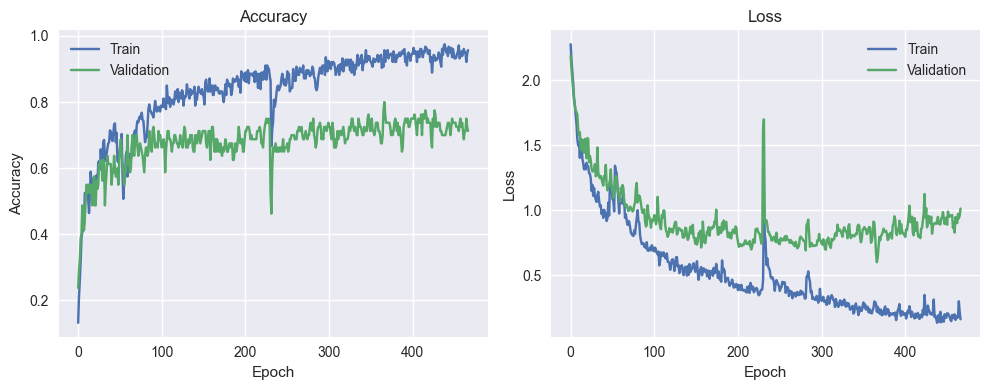

Best validation accuracy:  0.800000011920929
Epoch for which we get the best validation accuracy:  366
Test loss: 0.9050397872924805
Test accuracy: 0.7250000238418579
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


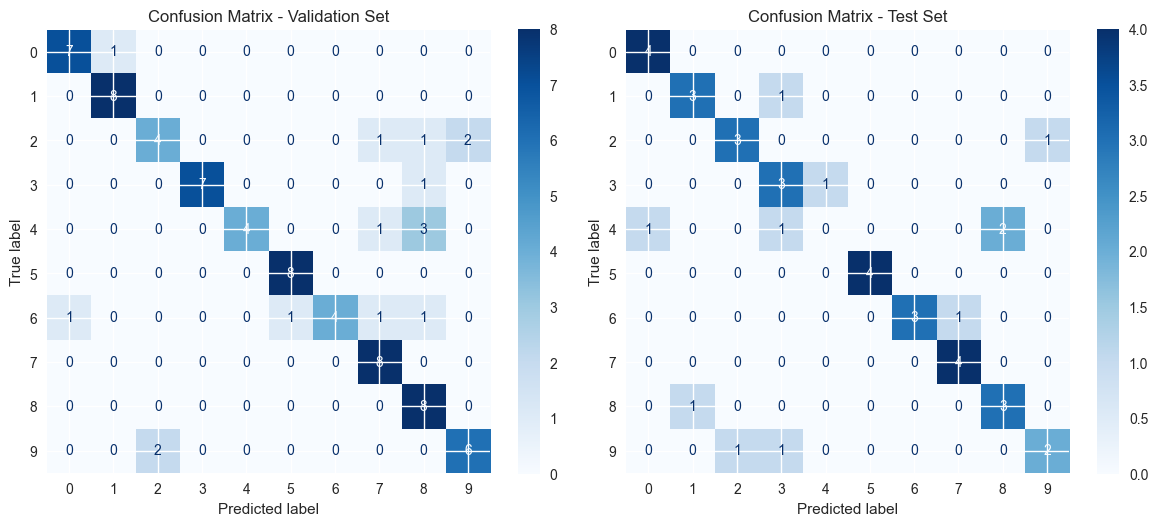

In [ ]:
log_df_hyb = pd.read_csv('training_1D_CNN_hyb.log')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_df_hyb['epoch'], log_df_hyb['accuracy'], label='Train')
plt.plot(log_df_hyb['epoch'], log_df_hyb['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log_df_hyb['epoch'], log_df_hyb['loss'], label='Train')
plt.plot(log_df_hyb['epoch'], log_df_hyb['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#best validation accuracy
best_acc = np.max(history_hyb.history['val_accuracy'])
best_acc_epoch = np.argmax(history_hyb.history['val_accuracy'])
print('Best validation accuracy: ', best_acc)
print('Epoch for which we get the best validation accuracy: ', best_acc_epoch)

model_hyb.load_weights('CNN_1D_model_hyb.h5')
[loss_test, acc_test] = model_hyb.evaluate(X_test_rss, y_test, verbose=0)
print(f"Test loss: {loss_test}")
print(f"Test accuracy: {acc_test}")

possible_classes = np.arange(0, 10)

pred_val = model_hyb.predict(X_val_rss)
pred_test = model_hyb.predict(X_test_rss)

pred_val_classes = np.argmax(pred_val, axis=1)
pred_test_classes = np.argmax(pred_test, axis=1)

# Confusion matrix computation
cm_val = confusion_matrix(y_val, pred_val_classes)
cm_test = confusion_matrix(y_test, pred_test_classes)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=possible_classes)
disp_val.plot(cmap=plt.cm.Blues, ax=axes[0], values_format='d')
axes[0].set_title('Confusion Matrix - Validation Set')


disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=possible_classes)
disp_test.plot(cmap=plt.cm.Blues, ax=axes[1], values_format='d')
axes[1].set_title('Confusion Matrix - Test Set')

plt.tight_layout()
plt.show()

In [105]:
print('------------ Validation set --------------')
print(classification_report(y_val, pred_val_classes))

print('---------------- Test set ------------------')
print(classification_report(y_test, pred_test_classes))

------------ Validation set --------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.89      1.00      0.94         8
           2       0.67      0.50      0.57         8
           3       1.00      0.88      0.93         8
           4       1.00      0.50      0.67         8
           5       0.89      1.00      0.94         8
           6       1.00      0.50      0.67         8
           7       0.73      1.00      0.84         8
           8       0.57      1.00      0.73         8
           9       0.75      0.75      0.75         8

    accuracy                           0.80        80
   macro avg       0.84      0.80      0.79        80
weighted avg       0.84      0.80      0.79        80

---------------- Test set ------------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.75      0.75      0.75 